# Reduced Displacement notebook

In this tutorial, we will explore Reduced Displacement data. 

Seismometers are (usually) velocity transducers - they generate an electric signal (in Volts) that is proportional to the velocity of ground shaking within a certain passband. Outside that passband, the seismometer no longer generates a voltage proportional to ground velocity. This voltage signal has to be digitized (using an analog-to-digital converter built into the datalogger or on a computer at the observatory), converting the signal units from Volts to digitizer "Counts" before it can be examined on a computer. This is a raw seismic signal. To convert this raw seismic signal to a velocity seismogram, we must "remove the instrument response". Then by carefully integrating the velocity seismogram, we will have a displacement seismogram. So we have raw, velocity, and displacement, seismograms.

RSAM is just one of several related downsampled seismic measurements. Some others supported by the `SAM` package are:

<table>
    <tr><th>Acronym</th><th>Full name</th><th>Computed from a:</th><th>Instrument corrected?</th><th>Geometrically corrected?</th><th>metric</th></tr>
    <tr><td>RSAM</td><td><b>Real-time (or Raw) Seismic Amplitude Measurement</b></td><td>Raw seismogram</td><td>N</td><td>N</td></tr>
    <tr><td>VSAM</td><td>Velocity Seismic Amplitude Measurement</td><td>Velocity seismogram</td><td>Y</td><td>N</td></tr>
    <tr><td>DSAM</td><td>Displacement Seismic Amplitude Measurement</td><td>Displacement seismogram</td><td>Y</td><td>N</td></tr>
    <tr><td>RSEM</td><td>Raw Seismic Energy Measurement</td><td>Raw seismogram</td><td>N</td><td>N</td></tr>   
    <tr><td>VSEM</td><td>Velocity Seismic Energy Measurement</td><td>Velocity seismogram</td><td>Y</td><td>N</td></tr>
    <tr><td>$V_R$</td><td>Reduced Velocity</td><td>VSAM</td><td>Y</td><td>Y</td></tr>  
    <tr><td>$D_R$</td><td><b>Reduced Displacement</b></td><td>DSAM</td><td>Y</td><td>Y</td></tr>   
    <tr><td>$E_R$</td><td><b>Reduced Energy</b></td><td>VSEM</td><td>Y</td><td>Y</td></tr>     
</table>

## 1. Correcting for Geometrical Spreading

How do we compare seismograms recorded at different distances from the same volcano? Or from different volcanoes? One thing we can do is to "reduce" the seismograms to a common distance, e.g. 1 km, by correcting for geometrical spreading. This is the idea behind Reduced Displacement. 

Consider a simple half-space velocity model of uniform density. As body waves propagate to greater distances, the wavefront can be thought of as a hemispherical shell, with surface area $2\pi{r}^2$. If energy is not dissipated inelastically or scattered, the energy per unit area must then diminish $1/{r}^2$. And since amplitude is proportional to the square root of energy, the amplitude of body waves diminishes like 1/r. We call this "geometrical spreading".

Similarly, surface waves can be thought of as a circular (or cylindrical) wavefront, whose circumference increases like $2\pi r$, so energy density diminishes like 1/r and surface wave amplitude as $1/\sqrt(r)$.

Reduced Displacement was introduced by Aki & Koyanagi (1981) as a measurement of volcanic tremor amplitude for Kilaeua. Proportional to seismic moment rate, it is the RMS amplitude of a displacement seismogram, corrected for geometrical spreading. 

For body waves:

$D_{R} = rms(U) r$

where r = distance from source to station, U = displacement

Beyond a few wavelengths, surface waves dominate, and Fehler (1983) determined:

$D_{RS} = rms(U) \sqrt{r \lambda}$

In a series of papers McNutt (1994; 2005; 2008) demonstrated scaling relationships for explosive volcanic eruptions between Reduced Displacement and:
- ash column height
- Volcanic Explosivity Index (Newhall and Self, 1982)
- cross-sectional area of volcanic vent

RSAM is generally more useful for seismic field engineers, because it is unfiltered. Reduced Displacement is generally more useful for scientists, as it is a measurement that can be compared from station to station, even on different volcanoes. 

References:

- Aki, K., Koyanagi, R.Y., 1981. Deep volcanic tremor and magma ascent mechanism under Kilauea, Hawaii. J. Geophys. Res. 86, 7095–7110.
- Fehler, M., 1983. Observations of volcanic tremor at Mount St. Helens Volcano. J. Geophys. Res. 88, 3476–3484.
- McNutt, S.R., 1994. Volcanic tremor amplitude correlated with the Volcanic Explosivity Index and its potential use in determining ash hazards to aviation. Acta Vulcanol. 5, 193–196.
- McNutt, S.R., Nishimura, T., 2008. Volcanic tremor during eruptions: Temporal characteristics, scaling and constraints on conduit size and processes. J. Volcanol. Geotherm. Res., 178, 1, 10-18. https://doi.org/10.1016/j.jvolgeores.2008.03.010.
- Newhall, C.G., Self, S., 1982. The volcanic explosivity index (VEI): an estimate of explosive magnitude for historical volcanism. J. Geophys. Res. 87, 1231–1238.

## 2. Computing Reduced Displacement

DSAM is just an instrument-corrected version of RSAM, and Reduced Displacement is just DSAM corrected for geometrical spreading, and so SAM.py was written to support all these different measurements. Here is an algorithm:

1. Load raw seismic data as an ObsPy Stream object.
2. Load station/instrument response metadata from a StationXML file into an Obspy Inventory object.
3. Remove instrument response to convert Stream object to a displacement seismogram.
4. Compute DSAM data from this displacement seismogram. 
6. Define a fixed source location.
7. Compute distance from station to source (done internally using source and inventory)
8. "Reduce" the DSAM object by multiplying by geometrical spreading correction.

### 2.1 Simple example

{'lat': 16.7164, 'lon': -62.1654}
METRIC:  mean


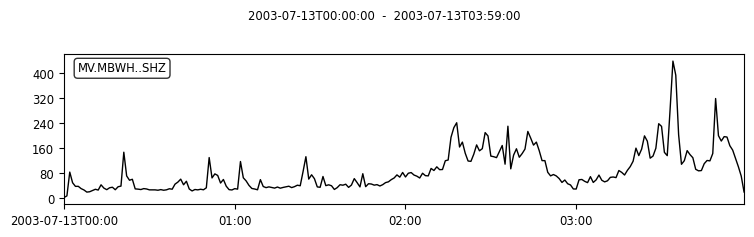

In [1]:
import os
import sys
import obspy
sys.path.append('../lib')
from SAM import DSAM 

# Load raw seismic data - and set units accordingly
DATA_DIR = os.path.join('..', '..', 'data')
SDS_DIR = os.path.join(DATA_DIR, 'continuous','SDS')
SAM_DIR = os.path.join(DATA_DIR, 'continuous','SAM')
RESPONSE_DIR = os.path.join(DATA_DIR, 'responses')

#mseedfile = os.path.join(SDS_DIR,'2009','AV','REF','EHZ.D', 'AV.REF..EHZ.D.2009.081' )
mseedfile = os.path.join(SDS_DIR,'2003','MV','MBWH','SHZ.D', 'MV.MBWH..SHZ.D.2003.194' )
st = obspy.read(mseedfile, 'MSEED')
for tr in st:
    tr.stats['units'] = 'Counts'

# load instrument response, remove instrument response from seismogram
#stationxml = os.path.join(RESPONSE_DIR, 'RD.xml')
stationxml = os.path.join(RESPONSE_DIR, 'MV.xml')
inv = obspy.read_inventory(stationxml)

# remove instrument response - and set units accordingly IMPORTANT!
#pre_filt = [0.01, 0.02, 25, 50]
pre_filt = [0.1, 0.2, 18, 25]
st.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP", plot=False) 
for tr in st:
    tr.stats['units'] = 'm'

#################################################
# So far we just have a displacement seismogram
#################################################

# Generate a Displacement Seismic Amplitude Measurement (DSAM) object - units must be 'm' else will not work
dsamObj = DSAM(stream=st, sampling_interval=60)

# Define a source location for Redoubt volcano. Station distances to this lat/lon are used to "reduce" the displacement to 1 km distance.
#source = {'lat':60.4845, 'lon':-152.7392}
source = {'lat':16.7164, 'lon':-62.1654}  
print(source)

# Generate a Reduced Displacement object, assuming body waves (surfaceWaves=False) and no inelastic attenuation (Q=None)
DRobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=False, Q=None)
DRobj.plot()


In [2]:
# Columns
print(DRobj.get_metrics())

Index(['min', 'mean', 'max', 'median', 'rms', 'VLP', 'LP', 'VT', 'fratio'], dtype='object')


The internal units of DR and DRS objects are metres at a distance of 1 km. To convert this to ${cm}^2$ we must multiply by 10^7. Hence the peaks on each of the last two plots correspond to 4.2 and 4.8 ${cm}^2$ respectively.

## 3. Comparing the Reduced Displacement of several eruptions

1-minute DSAM data have been pre-computed for several eruptions. We will now load these, compute Reduced Displacement, and compare them. The general syntax we will use to read DSAM data and compute Reduced Displacement is:

```
dsamObj = DSAM.read(startTime, endTime, SAM_DIR='/path/to/DSAM/data/directory', sampling_interval=sampling_interval, ext=ext)
DRobj = dsamObj.compute_reduced_displacement(inventory, source, surfaceWaves=False, Q=None)
```
We will capture the highest reduced displacement into a results DataFrame, resultsDF.

For reasons that will become clearer later, we will compute Reduced Displacement in two frequency bands. The default is 0.5-18.0 Hz. The second is a VLP passband, from 0.02 to 0.2 Hz. We write a function, compute_reduced_displacements, so we don't have to keep repeating the same code block:

In [3]:
import os
import sys
import glob
import pandas as pd
import obspy
sys.path.append('../lib')
#import setup_paths
#paths = setup_paths.paths
from SAM import DSAM

resultsDF = pd.DataFrame(columns=['Event', 'DR', 'DRS', 'DRS_VLP'])

def compute_reduced_displacements(eventname, dsamObj, source, stationxml, resultsDF, surfaceWaveSpeed_kms=2.0, peakf=None):

    dsamObj = dsamObj.select(component='Z')
    inv = obspy.read_inventory(stationxml)
    
    # body wave reduced displacement
    DRobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=False, Q=None, wavespeed_kms=surfaceWaveSpeed_kms, peakf=peakf)
    DRobj.plot(metrics='rms')
    DRmaxrms = DRobj.max(metric='rms')
    
    # surface wave reduced displacement
    DRSobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=True, Q=None, wavespeed_kms=surfaceWaveSpeed_kms, peakf=peakf)
    DRSobj.plot(metrics='rms')   
    DRSmaxrms = DRSobj.max(metric='rms')
    DRSmaxvlp = DRSobj.max(metric='VLP')
    
    # add to results
    resultsDF.loc[len(resultsDF.index)] = [eventname, DRmaxrms, DRSmaxrms, DRSmaxvlp]
    

### 3.1 Event 1: Boxing Day Collapse 1997, Montserrat

29 months into the eruption of the Soufriere Hills Volcano, Montserrat, part of the crater wall the lava dome was growing within (and overtopping) suddenly collapsed in a landslide, causing a sideways explosion of the lava dome which effectively removed all traces of villages in the southwest quadrant of Montserrat (the villages had been evacuated more than a year earlier). At this time, there were only 2 stations operational, due to months of pyroclastic flows which had destroyed the capital, Plymouth, the airport, numerous other villages, and several seismic stations, and it was much too dangerous to replace them.

METRIC:  rms


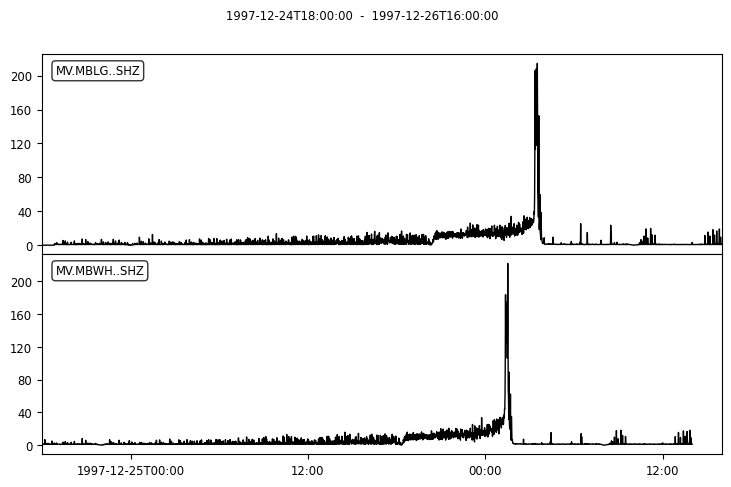

,seed_id,DR
0,MV.MBWH..SHZ,221.75
1,MV.MBLG..SHZ,214.49
2,Network,218.12


METRIC:  rms


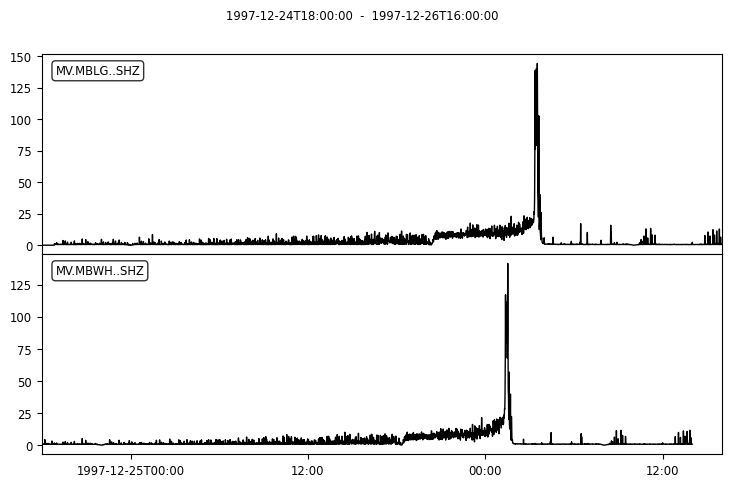

,seed_id,DRS
0,MV.MBWH..SHZ,141.57
1,MV.MBLG..SHZ,144.33
2,Network,142.95


,seed_id,DRS
0,MV.MBWH..SHZ,23.82
1,MV.MBLG..SHZ,145.13
2,Network,84.48


In [4]:
# Event name
eventname1 = 'Boxing Day Collapse 1997'
source1 = {'lat':16.71111, 'lon':-62.17722}
stationxml1 = os.path.join(RESPONSE_DIR, 'MV.xml')
startt1 = obspy.UTCDateTime(1997,12,24,18,0,0)
endt1 = obspy.UTCDateTime(1997,12,27,6,0,0)
dsamObj1 = DSAM.read(startt1, endt1, SAM_DIR, sampling_interval=60, ext='pickle', trace_ids=['MV.MBWH..SHZ', 'MV.MBLG..SHZ'])
compute_reduced_displacements(eventname1, dsamObj1, source1, stationxml1, resultsDF)

In this example, for the regular passband, we get very similar values of reduced displacement whether we assume body waves or surface waves - both around 217 ${cm}^2$. In the VLP passband, the signal is 10 times smaller, which isn't surprising as the only stations available had short-period seismometers.

### 3.2 July 12th 2003 Dome collapse, Montserrat
On July 12th, 2003, over 200 million ${m}^3$ of the lava dome collapse in a series of explosions and pyroclastic flows, over a few hours. Let's compare the Reduced Displacement of this event to the Boxing Day 1997 collapse we just examined. Since this collapse happened mostly down the Tar River Valley, we will pick a source location there, rather than one centred on the lava dome.

METRIC:  rms


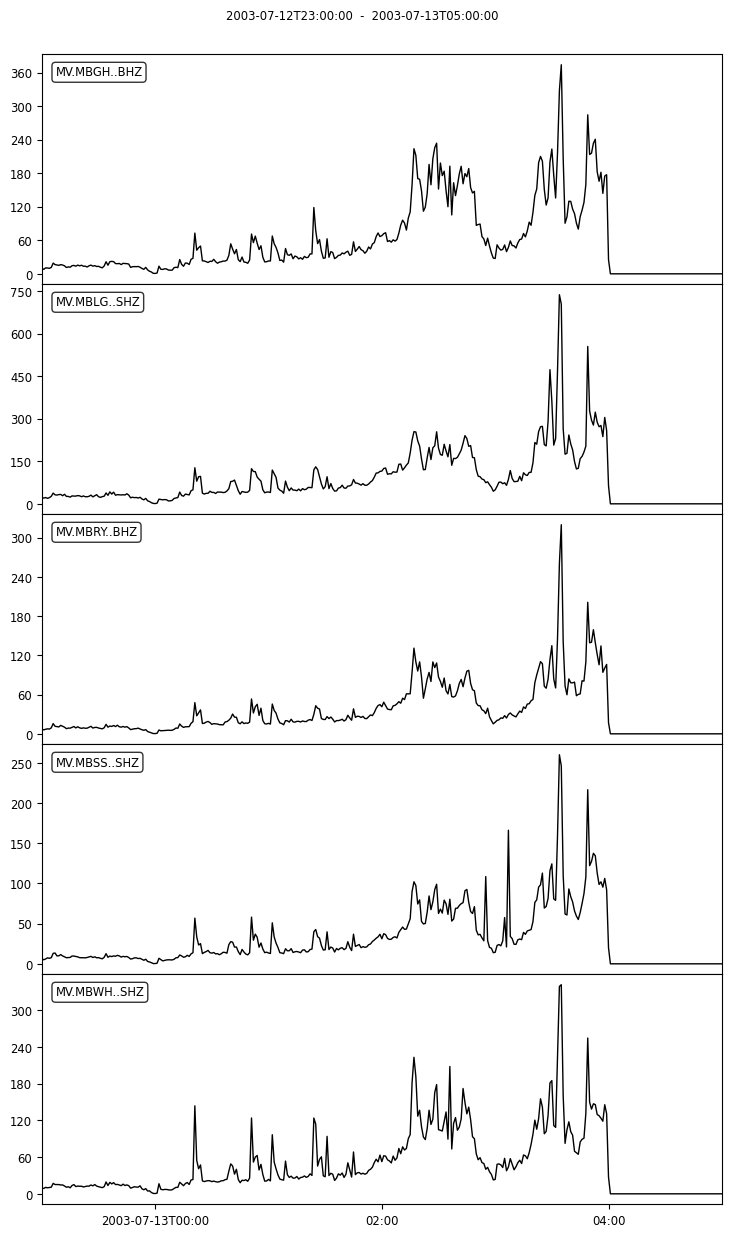

,seed_id,DR
0,MV.MBGH..BHZ,374.02
1,MV.MBLG..SHZ,737.25
2,MV.MBRY..BHZ,319.61
3,MV.MBSS..SHZ,260.13
4,MV.MBWH..SHZ,341.51
5,Network,341.51


METRIC:  rms


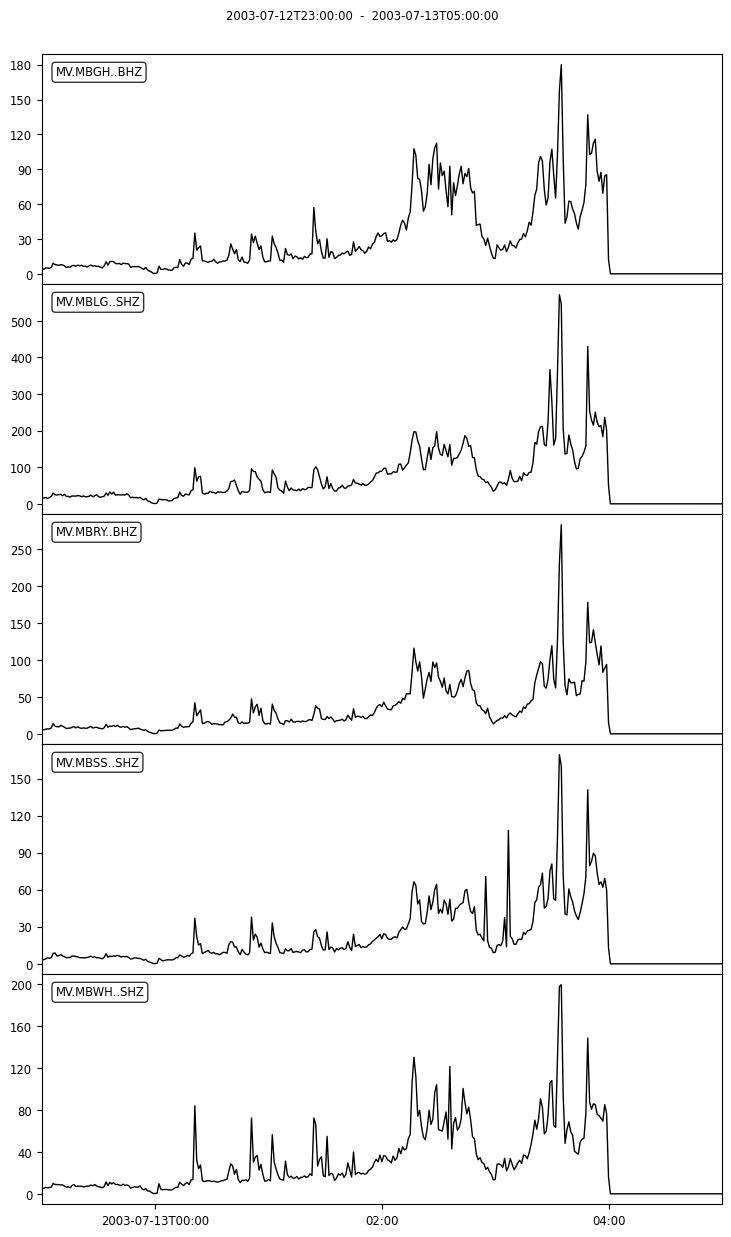

,seed_id,DRS
0,MV.MBGH..BHZ,179.97
1,MV.MBLG..SHZ,571.30
2,MV.MBRY..BHZ,283.02
3,MV.MBSS..SHZ,169.32
4,MV.MBWH..SHZ,199.63
5,Network,199.63


,seed_id,DRS
0,MV.MBGH..BHZ,1199.15
1,MV.MBLG..SHZ,820.41
2,MV.MBRY..BHZ,2566.73
3,MV.MBSS..SHZ,886.06
4,MV.MBWH..SHZ,340.81
5,Network,886.06


In [5]:
eventname2 = '2003/07/12 collapse, Montserrat'
stationxml2 = os.path.join(RESPONSE_DIR, 'MV.xml')
source2 = {'lat':16.7164, 'lon':-62.1654}  # Tar River
startt2 = obspy.UTCDateTime(2003,7,12,23,0,0)
endt2 = obspy.UTCDateTime(2003,7,13,5,0,0)
dsamObj2 = DSAM.read(startt2, endt2, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', \
                    trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'])
compute_reduced_displacements(eventname2, dsamObj2, source2, stationxml2, resultsDF)

### 3.3 Phreatic eruption, Whakaari, Dec 9th, 2019

Whakaari - otherwise known as White Island - is the subaerial tip of a 1600 m high volcano that rises from the seafloor. Tourists arriving by boat and helicopter take a short hike into an open volcanic crater, past fumaroles, to an overlook of the crater lake. Phreatic eruptions are particularly difficult to forecast, as unlike magmatic eruptions, there are no seismic precursors (or indeed any other precuroses) that have been identified. Sadly, this particulary eruption led to the deaths of 22 tourists and guides. Let's compute the Reduced Displacement of this event.


/home/thompsong/miniconda3/envs/skience24/lib/python3.11/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


METRIC:  rms


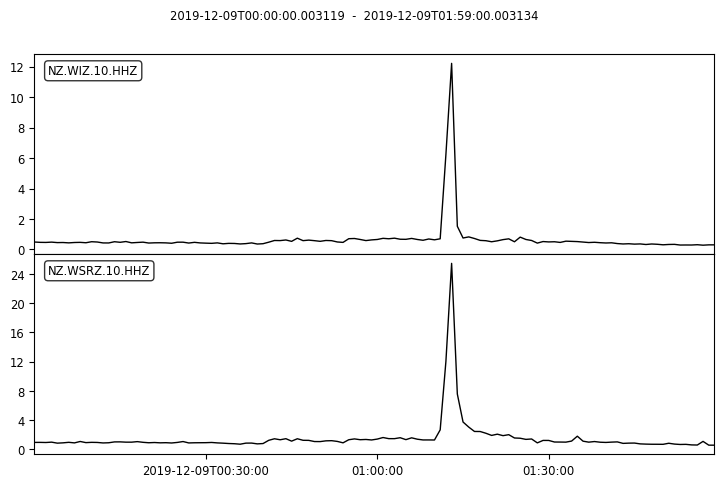

,seed_id,DR
0,NZ.WSRZ.10.HHZ,25.43
1,NZ.WIZ.10.HHZ,12.21
2,Network,18.82


/home/thompsong/miniconda3/envs/skience24/lib/python3.11/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


METRIC:  rms


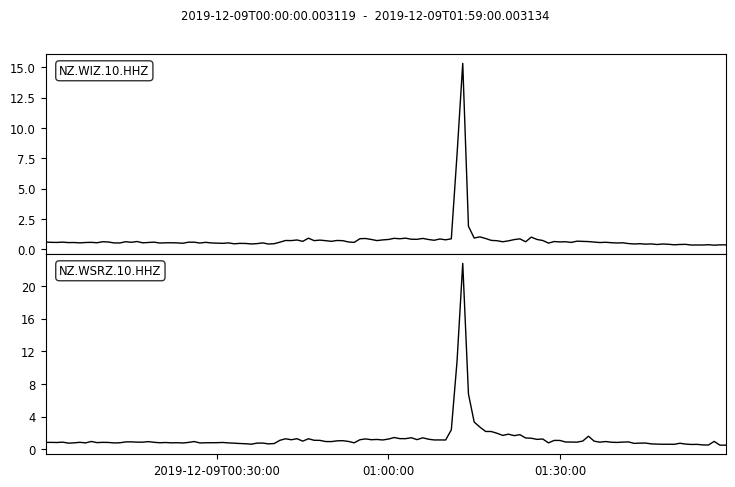

,seed_id,DRS
0,NZ.WSRZ.10.HHZ,22.79
1,NZ.WIZ.10.HHZ,15.31
2,Network,19.05


,seed_id,DRS
0,NZ.WSRZ.10.HHZ,166.02
1,NZ.WIZ.10.HHZ,877.46
2,Network,521.74


In [6]:
eventname3 = '2019/12/09 Phreatic explosion, Whakaari'
stationxml3 = os.path.join(RESPONSE_DIR, 'NZ.xml')
source3 = {'lat':-37.5217, 'lon':177.185}
startt3 = obspy.UTCDateTime(2019,12,9,0,0,0)
endt3 = obspy.UTCDateTime(2019,12,9,2,0,0)
dsamObj3 = DSAM.read(startt3, endt3, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle')
compute_reduced_displacements(eventname3, dsamObj3, source3, stationxml3, resultsDF)

So this was a much smaller event - a Reduced Displacement of ~20 ${cm}^2$. It was also short in duration - just a few minutes long. But tourist groups inside the crater stood no chance.

### 3.4 Sub-Plinian eruption of Redoubt volcano, March 23, 2009

Redoubt volcano in Alaska had been in a state of unrest for 2-3 months, with deep-long-period earthquakes, deformation, swarms, and tremor, before explosively erupting at least 18 times between March 23rd and March 28th, 2009. We look only at March 23rd. There were actually 5 major explosive events on this day, which began at 6:38am (18,000 ft), 7:02am (44,000 ft), 08:14am (43,000 ft), 9:39am (43,000 ft), and 12:31pm (49,000 ft). 

The seismic data come from an analog telemetry system, and most channels are heavily contaminated by large interference spikes, and if we don't remove these, we'll end up with Reduced Displacement of ~10^7 ${cm}^2$ !! It turns out there are only two stations free of this noise, RDN and REF, although these also become contaminated from around 3pm onwards.

The seismograms look clean, so now we'll compute the DSAM data and apply a clip level of 0.01 mm to the displacement seismogram. This might take 1-2 minutes because it is computing DSAM data for 24 hours of multi-channel data.

METRIC:  rms


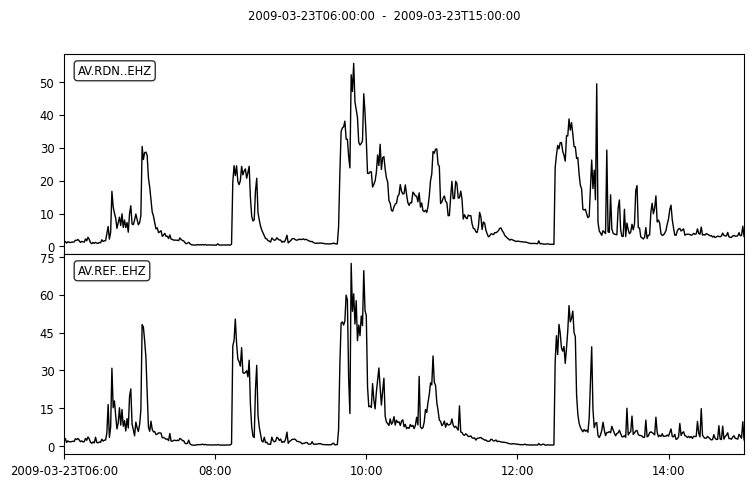

,seed_id,DR
0,AV.RDN..EHZ,55.61
1,AV.REF..EHZ,72.42
2,Network,64.02


METRIC:  rms


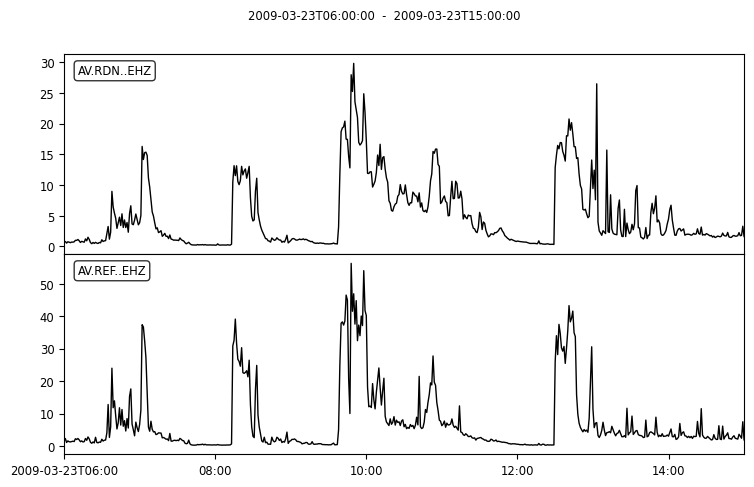

,seed_id,DRS
0,AV.RDN..EHZ,29.84
1,AV.REF..EHZ,56.31
2,Network,43.07


,seed_id,DRS
0,AV.RDN..EHZ,992.09
1,AV.REF..EHZ,635.87
2,Network,813.98


In [7]:
startt4 = obspy.UTCDateTime(2009,3,23,6,0,0)
endt4 = obspy.UTCDateTime(2009,3,23,15,0,0)
dsamObj4 = DSAM.read(startt4, endt4, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle')
dsamObj4 = dsamObj4.select(channel='EHZ')
for station in ['RDE', 'NCT', 'RSO', 'DFR', 'RED', 'RDT']:
    dsamObj4.drop(id=f'AV.{station}..EHZ')
eventname4 = '2009/03/23 Redoubt Sub-Plinian eruptions'
stationxml4 = os.path.join(RESPONSE_DIR, 'AV.xml')
source4 = {'lat':60.4845, 'lon':-152.7392}
compute_reduced_displacements(eventname4, dsamObj4, source4, stationxml4, resultsDF)

### 3.5 Hunga Tonga eruption, Jan 15th, 2022

Our final example is Hunga Tonga, which on January 15th, 2022, exploded spectacularly, destroying most of the island, generating a tsunami, and seismic, pressure and gravity waves that propagated around the globe several times. 

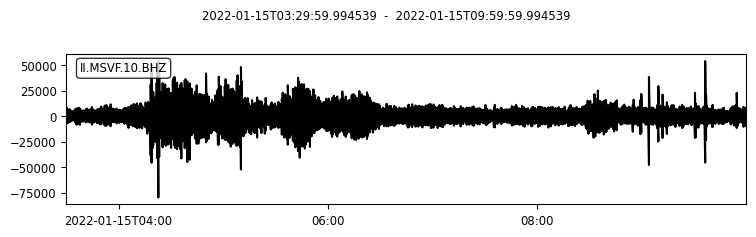

In [8]:
from obspy.clients.filesystem.sds import Client as sdsclient
eventname5 = 'Hunga Tonga, 2022/01/15'
mySDSclient = sdsclient('/data/SDS')
startt5 = obspy.UTCDateTime(2022,1,15,3,30,0)
endt5 = obspy.UTCDateTime(2022,1,15,10,0,0)
st = mySDSclient.get_waveforms("II", "MSVF", "10", "BHZ", startt5, endt5)
for tr in st:
    tr.stats.units='Counts'
st.plot(equal_scale=False);

METRIC:  rms


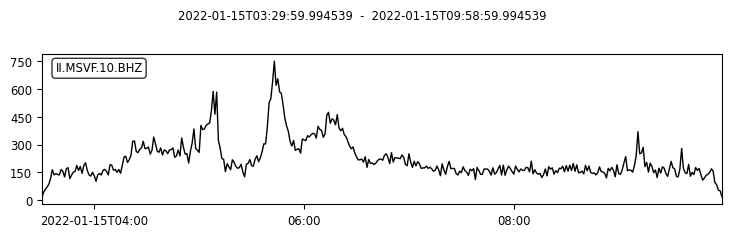

,seed_id,DR
0,II.MSVF.10.BHZ,751.43
1,Network,751.43


METRIC:  rms


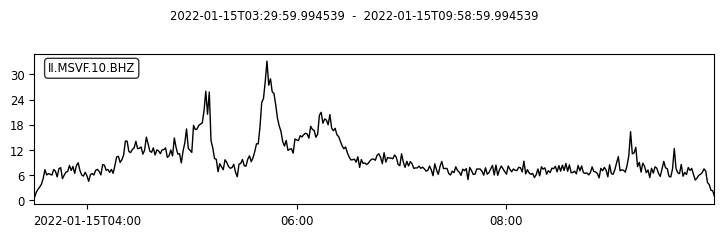

,seed_id,DRS
0,II.MSVF.10.BHZ,33.18
1,Network,33.18


,seed_id,DRS
0,II.MSVF.10.BHZ,39142.68
1,Network,39142.68


In [9]:
pre_filt = [0.04, 0.05, 18, 25]
stationxml5 = os.path.join(RESPONSE_DIR, 'II.xml')
inv = obspy.read_inventory(stationxml5)
st.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP", plot=False) 
for tr in st:
    tr.stats['units'] = 'm'

#################################################
# So far we just have a displacement seismogram
#################################################

# Generate a Displacement Seismic Amplitude Measurement (DSAM) object - units must be 'm' else will not work
dsamObj5 = DSAM(stream=st, sampling_interval=60)

source5 = {'lat':-20.57, 'lon':-175.38}

compute_reduced_displacements(eventname5, dsamObj5, source5, stationxml5, resultsDF, surfaceWaveSpeed_kms=3.0)

## 4. Results

In [10]:
display(resultsDF)

,Event,DR,DRS,DRS_VLP
0,Boxing Day Collapse 1997,218.12,142.95,84.48
1,"2003/07/12 collapse, Montserrat",341.51,199.63,886.06
2,"2019/12/09 Phreatic explosion, Whakaari",18.82,19.05,521.74
3,2009/03/23 Redoubt Sub-Plinian eruptions,64.02,43.07,813.98
4,"Hunga Tonga, 2022/01/15",751.43,33.18,39142.68


Which values are reasonable to accept?
- For event 0, there were only short-period seismometers available, so the VLP-band results should be ignored. Since we are at local distances, we expect body waves to dominate, so we choose $D_R$ over $D_{RS}$ and accept 218 ${cm}^2$.
- For event 1, while broadband seismometers were available, the VLP-band results are lower. Again, we prefer $D_R$ over $D_{RS}$, since we are at local distances, so we accept 342 ${cm}^2$.
- For event 2, while the VLP bands show higher results, Whakaari is a small island, so the VLP energy likely comes from ocean noise. Again, we are at the local scale, so we accept 18.8 ${cm}^2$.
- For event 3, Redoubt is coastal, and we are at local distances, so we choose $D_R$, and accept 64 ${cm}^2$.
- For event 4, station MSVF is about 760 km from Hunga Tonga, so surface waves dominate, and most of the signal is between 0.01 and 0.6 Hz. Is the $D_{RS}^{VLP}$ value of 39,000 ${cm}^2$ reasonable? 

Clearly, we must be very careful applying the same measurements at local, regional, and global scales!

#### CAVEAT: We ignored inelastic attenuation in this analysis. Including it would make Reduced Displacement estimates even higher!

Finally, there is a sort of "magnitude scale" for volcanic eruptions called the Volcanic Explosivity Index (VEI), which similar to earthquake magnitude scales, runs from about 1 to 8. However, VEI is not an instrumental measurement, and instead is estimated from the volume of deposits found, and the height an ash column reaches, and other things. Hunga Tonga was estimated by different researchers to be either a VEI=5 or VEI=6 eruption, so if we fix that at VEI=5.5 and throw caution to the wind, here are instrumental VEI estimates for the other events above too:

In [11]:
import numpy as np
correction = 5.5 - np.log10(39142.68)
for DR  in [218.12, 341.51, 18.82, 64.02, 39142.68]:
    VEI = np.log10(DR) + correction
    print(f'DR={DR:.1f}, VEI={VEI:.1f}')

DR=218.1, VEI=3.2
DR=341.5, VEI=3.4
DR=18.8, VEI=2.2
DR=64.0, VEI=2.7
DR=39142.7, VEI=5.5


They do actually seem quite reasonable! :-p